### Importy

In [13]:
import pandas as pd
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.optimizers import Adam
from transformers import pipeline
from tqdm import tqdm
from keras_preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

### Pobiernie danych

In [2]:
!kaggle datasets download -d shivamkushwaha/bbc-full-text-document-classification --unzip

Dataset URL: https://www.kaggle.com/datasets/shivamkushwaha/bbc-full-text-document-classification
License(s): DbCL-1.0




  0%|          | 0.00/5.59M [00:00<?, ?B/s]
 18%|#7        | 1.00M/5.59M [00:00<00:03, 1.58MB/s]
 36%|###5      | 2.00M/5.59M [00:00<00:01, 3.16MB/s]
 72%|#######1  | 4.00M/5.59M [00:00<00:00, 6.34MB/s]
100%|##########| 5.59M/5.59M [00:00<00:00, 6.05MB/s]


## Sprawdzenie dostępności GPU

In [2]:
# Check GPU availability
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
print(tf.config.list_physical_devices('GPU'))


Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Ładowanie danych

In [40]:
datapath = 'bbc/'
directory, file, title, text, label = [], [], [], [], []
for dirname, _, filenames in os.walk(datapath):
    for filename in filenames:
        if filename == 'README.TXT':
            continue
        directory.append(dirname)
        file.append(filename)
        label.append(dirname.split('/')[-1])
        fullpathfile = os.path.join(dirname, filename)
        with open(fullpathfile, 'r', encoding="utf8", errors='ignore') as infile:
            intext = ''
            firstline = True
            for line in infile:
                if firstline:
                    title.append(line.replace('\n', ''))
                    firstline = False
                else:
                    intext += ' ' + line.replace('\n', '')
            text.append(intext)


## Konwersja na DataFrame

In [41]:
df = pd.DataFrame(list(zip(directory, file, title, text, label)), columns=['directory', 'file', 'title', 'text', 'label'])
df = df.filter(['title', 'text', 'label'], axis=1)

In [42]:
df.head()

title  \
0  Ad sales boost Time Warner profit   
1   Dollar gains on Greenspan speech   
2  Yukos unit buyer faces loan claim   
3  High fuel prices hit BA's profits   
4  Pernod takeover talk lifts Domecq   

                                                text     label  
0    Quarterly profits at US media giant TimeWarn...  business  
1    The dollar has hit its highest level against...  business  
2    The owners of embattled Russian oil giant Yu...  business  
3    British Airways has blamed high fuel prices ...  business  
4    Shares in UK drinks and food firm Allied Dom...  business

In [7]:
df.shape

(2225, 3)

In [8]:
df["label"].unique()

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

In [9]:
df.isnull().sum() # Sprawdzenie brakujących wartości

title    0
text     0
label    0
dtype: int64

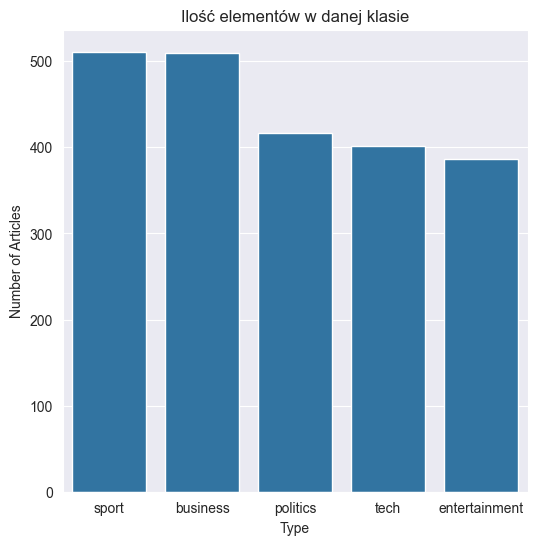

In [10]:
label_counts = df['label'].value_counts()

plt.figure(figsize=(6, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Ilość elementów w danej klasie")
plt.xlabel("Type")
plt.ylabel("Number of Articles")
plt.show()

## Podział danych na zbiory treningowy, walidacyjny i testowy

In [43]:
X_train_full, X_test, y_train_full, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [44]:
X_train.shape, X_val.shape, X_test.shape

((1424,), (356,), (445,))

## Tf-idf z wykorzystaniem Naive Bayes

In [8]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [9]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)

MultinomialNB()

In [10]:
y_pred = nb_classifier.predict(X_test_tfidf)
nb_accuracy = accuracy_score(y_test, y_pred)
print(f'Naive Bayes Accuracy: {nb_accuracy}')

Naive Bayes Accuracy: 0.9707865168539326


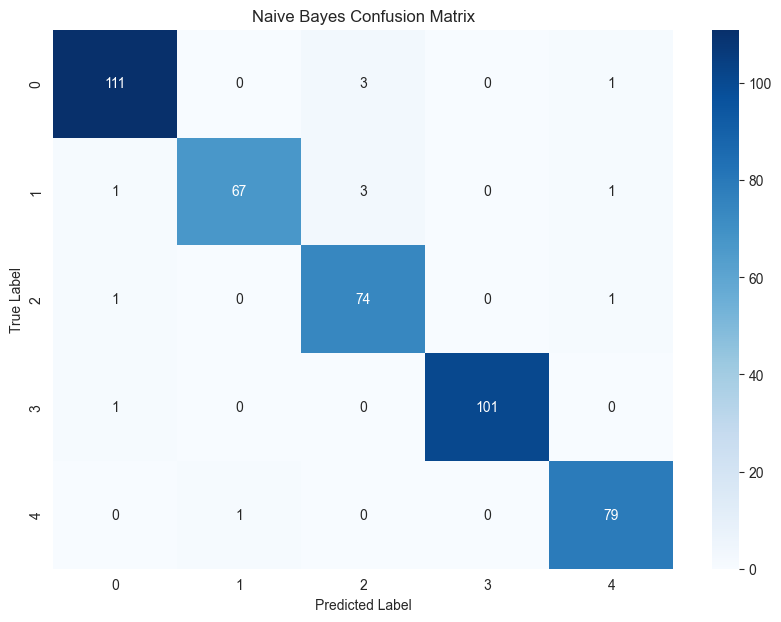

In [11]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Naive Bayes Confusion Matrix')
plt.show()

In [15]:
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

     business       0.97      0.97      0.97       115
entertainment       0.99      0.93      0.96        72
     politics       0.93      0.97      0.95        76
        sport       1.00      0.99      1.00       102
         tech       0.96      0.99      0.98        80

     accuracy                           0.97       445
    macro avg       0.97      0.97      0.97       445
 weighted avg       0.97      0.97      0.97       445



## LSTM

### Przygotowanie danych

In [31]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y_train)

In [32]:
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y_train = onehot_encoder.fit_transform(integer_encoded)
integer_encoded = label_encoder.transform(y_val).reshape(len(y_val), 1)
y_val = onehot_encoder.transform(integer_encoded)
integer_encoded = label_encoder.transform(y_test).reshape(len(y_test), 1)
y_test = onehot_encoder.transform(integer_encoded)

### Tokenizacja

In [33]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

In [34]:
X_train = pad_sequences(X_train, maxlen=1000)
X_val = pad_sequences(X_val, maxlen=1000)
X_test = pad_sequences(X_test, maxlen=1000)

### Model

In [35]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=1000),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(y_train.shape[1], activation='softmax')
])
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/15
23/23 [==============================] - 8s 147ms/step - loss: 1.5697 - accuracy: 0.2725 - val_loss: 1.2654 - val_accuracy: 0.4410
Epoch 2/15
23/23 [==============================] - 2s 108ms/step - loss: 1.1485 - accuracy: 0.4698 - val_loss: 1.1248 - val_accuracy: 0.5197
Epoch 3/15
23/23 [==============================] - 2s 109ms/step - loss: 0.8194 - accuracy: 0.6678 - val_loss: 0.6958 - val_accuracy: 0.8090
Epoch 4/15
23/23 [==============================] - 2s 107ms/step - loss: 0.3153 - accuracy: 0.9178 - val_loss: 0.4955 - val_accuracy: 0.8624
Epoch 5/15
23/23 [==============================] - 2s 104ms/step - loss: 0.1949 - accuracy: 0.9396 - val_loss: 0.4209 - val_accuracy: 0.8567
Epoch 6/15
23/23 [==============================] - 2s 106ms/step - loss: 0.0780 - accuracy: 0.9860 - val_loss: 0.5346 - val_accuracy: 0.8567
Epoch 7/15
23/23 [==============================] - 2s 106ms/step - loss: 0.0673 - accuracy: 0.9874 - val_loss: 0.4814 - val_accuracy: 0.8904
Epoch 

### Ocena modelu

In [36]:
val_loss, val_accuracy = model.evaluate(X_val, y_val)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'LSTM Validation Accuracy: {val_accuracy}, loss: {val_loss}')
print(f'LSTM Test Accuracy: {test_accuracy}, loss: {test_loss}')


14/14 [==============================] - 1s 34ms/step - loss: 0.5677 - accuracy: 0.8629
LSTM Validation Accuracy: 0.8904494643211365, loss: 0.4512944519519806
LSTM Test Accuracy: 0.8629213571548462, loss: 0.5676819086074829


In [37]:
y_pred = model.predict(X_test)
y_pred = onehot_encoder.inverse_transform(y_pred)
y_test = onehot_encoder.inverse_transform(y_test)
y_pred = label_encoder.inverse_transform(y_pred)
y_test = label_encoder.inverse_transform(y_test)

14/14 [==============================] - 1s 35ms/step


C:\Users\adamw\PycharmProjects\pythonProject\venv\lib\site-packages\sklearn\preprocessing\_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


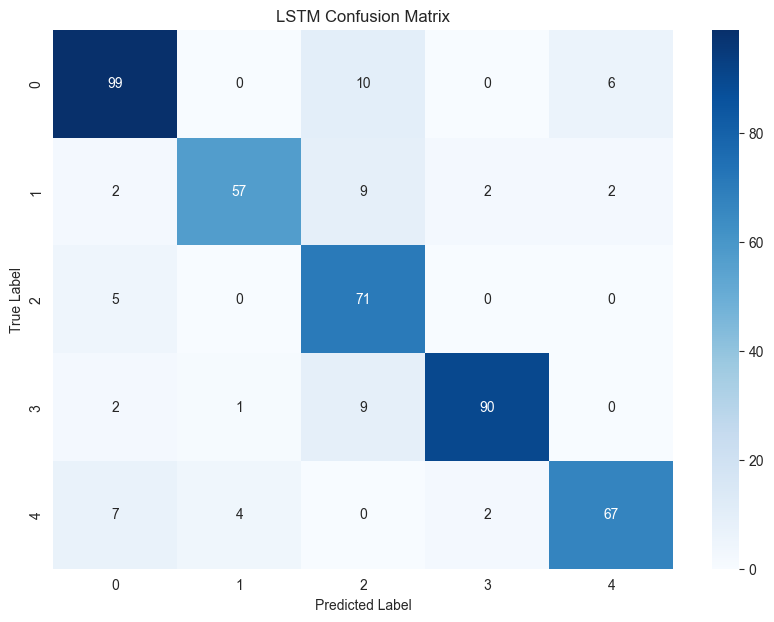

In [38]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('LSTM Confusion Matrix')
plt.show()

In [39]:
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

     business       0.86      0.86      0.86       115
entertainment       0.92      0.79      0.85        72
     politics       0.72      0.93      0.81        76
        sport       0.96      0.88      0.92       102
         tech       0.89      0.84      0.86        80

     accuracy                           0.86       445
    macro avg       0.87      0.86      0.86       445
 weighted avg       0.87      0.86      0.86       445



## Trnsformers pipeline na pre-trenowanym modelu

In [45]:
# Encode labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Split data
X_train_full, X_test, y_train_full, y_test = train_test_split(df['text'], df['label_encoded'], test_size=0.2,
                                                              random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)


In [46]:
classifier = pipeline('text-classification', model='distilbert-base-uncased')
def get_predictions(texts):
    predictions = []
    for text in tqdm(texts, desc="Processing"):
        result = classifier(text, truncation=True)
        predicted_label = int(result[0]['label'].split('_')[-1])
        predictions.append(predicted_label)
    return predictions


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
val_predictions = get_predictions(X_val)
test_predictions = get_predictions(X_test)
trans_val_accuracy = (val_predictions == y_val).mean()
trans_test_accuracy = (test_predictions == y_test).mean()
print(f'Pre-trained Model Validation Accuracy: {trans_val_accuracy}')
print(f'Pre-trained Model Test Accuracy: {trans_test_accuracy}')

Processing: 100%|██████████| 445/445 [02:47<00:00,  2.66it/s]

Pre-trained Model Validation Accuracy: 0.20224719101123595
Pre-trained Model Test Accuracy: 0.25842696629213485


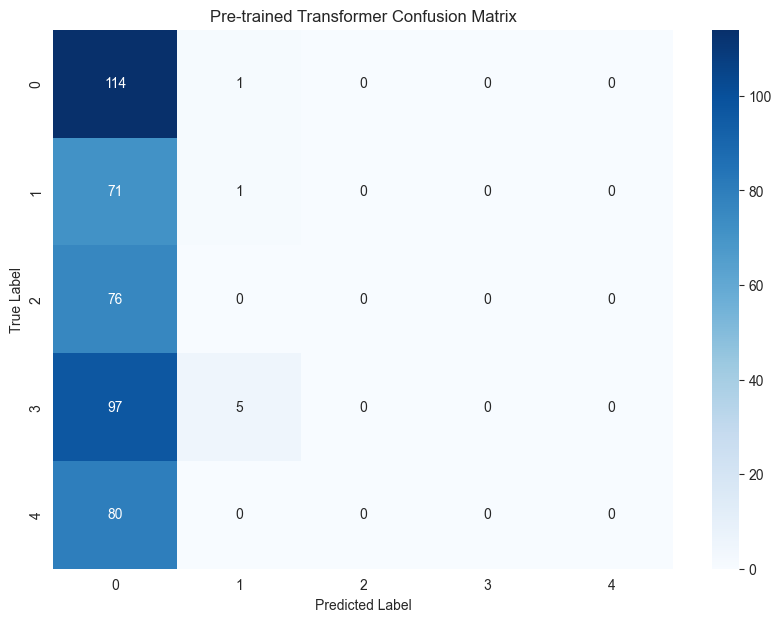

In [48]:
conf_matrix = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Pre-trained Transformer Confusion Matrix')
plt.show()

In [49]:
print(classification_report(y_test, test_predictions))

              precision    recall  f1-score   support

           0       0.26      0.99      0.41       115
           1       0.14      0.01      0.03        72
           2       0.00      0.00      0.00        76
           3       0.00      0.00      0.00       102
           4       0.00      0.00      0.00        80

    accuracy                           0.26       445
   macro avg       0.08      0.20      0.09       445
weighted avg       0.09      0.26      0.11       445



C:\Users\adamw\PycharmProjects\pythonProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\adamw\PycharmProjects\pythonProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\adamw\PycharmProjects\pythonProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

## Podsumowanie

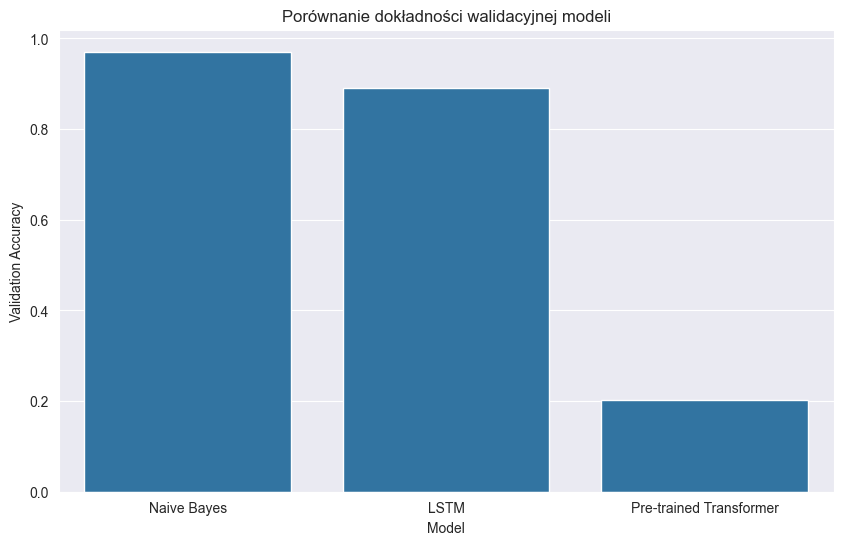

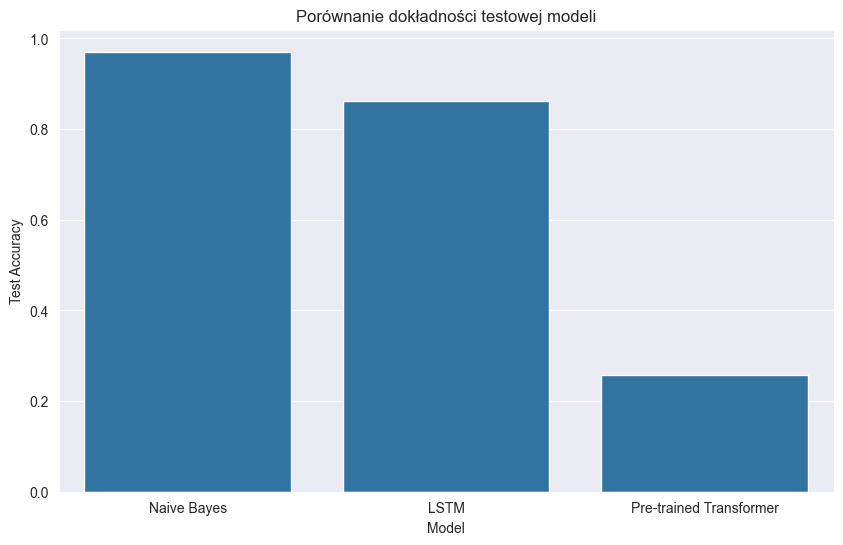

In [50]:
results = pd.DataFrame({
    'Model': ['Naive Bayes', 'LSTM', 'Pre-trained Transformer'],
    'Validation Accuracy': [nb_accuracy, val_accuracy, trans_val_accuracy],
    'Test Accuracy': [nb_accuracy, test_accuracy, trans_test_accuracy]
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Validation Accuracy', data=results)
plt.title('Porównanie dokładności walidacyjnej modeli')
plt.ylabel('Validation Accuracy')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Test Accuracy', data=results)
plt.title('Porównanie dokładności testowej modeli')
plt.ylabel('Test Accuracy')
plt.show()